# Nested sampling
Nous avons vu en classe la procédure étape par étape du Nested sampling.
Le but de ce notebook est d'implémenter l'algorithme nous-même.
En pratique, pour le reste du cours, nous utiliserons dynesty.
On peut cependant acquérir une bonne intuition de comment le nested sampling fonction en codant une version simple.

L'algorithme est donné dans les diapos vues en classe et discuté en plus grand détail dans l'article de Skilling (2006) disponible sur StudiUM.

## Définition d'un modèle 1D simple

Pour commencer, nous allons tester notre implémentation sur une vraisemblance normale 1D avec une moyenne $\mu = 0$ et $\sigma = 1$, avec une distribution à priori entre -10 et 10.

### Transformation du prior

Pour implémenter le prior, il faut une "transformation du prior" (CDF inverse), comme nous avons vu en classe.
Cette fonction doit transformer des échantillons d'un intervalle unitaire vers la distribution souhaitée, soit $\mathcal{U}(-5, 5)$ dans ce cas-ci.

**Pour cette partie-ci, nous allons:**

- **Coder la transformation du prior dans la fonction `prior_transform()`.**
- **Tester notre transformation avec un échantillonnage aléatoire** (vérifiez que l'histogramme donne la distribution uniforme attendue entre -5 et 5.

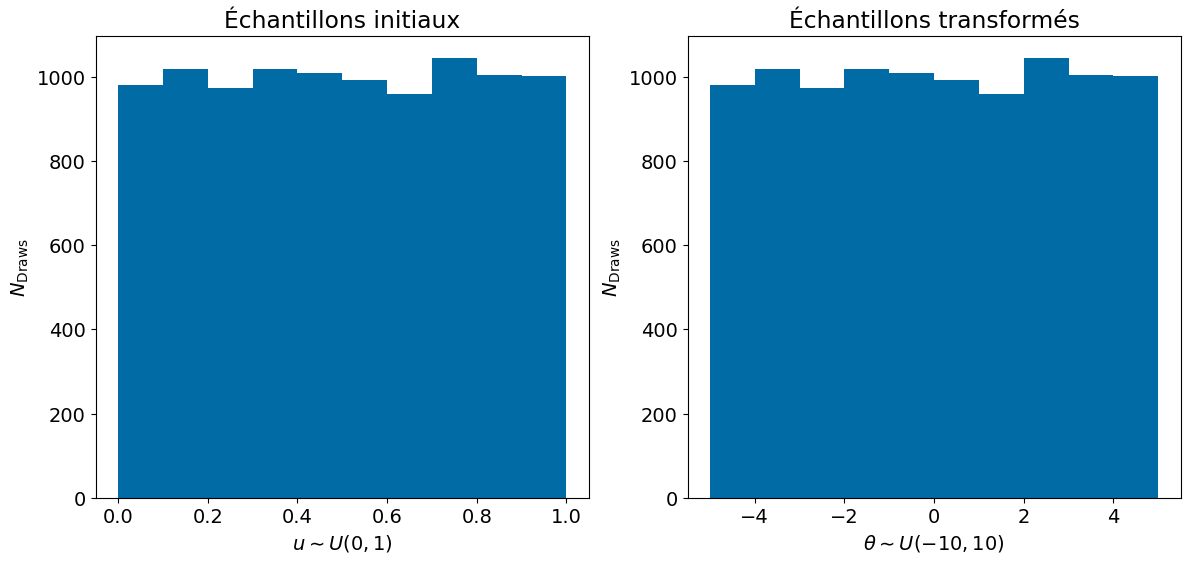

In [2]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from matplotlib import rcParams
from numpy.typing import NDArray

plt.style.use("tableau-colorblind10")

rcParams["font.size"] = 14


def prior_transform(u: NDArray) -> NDArray:
    """Prior transofmr pour un prior uniforme entre -5 et 5.

    :param u: Échantillons entre 0 et 1
    :return: Échantillons entre -5 et 5
    """
    return u * 10 - 5


rng = np.random.default_rng(3051)
utest = rng.uniform(size=10_000)
ptest = prior_transform(utest)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
axs[0].hist(utest)
axs[0].set_xlabel(r"$u \sim U(0, 1)$")
axs[0].set_ylabel(r"$N_\text{Draws}$")
axs[0].set_title("Échantillons initiaux")
axs[1].hist(ptest)
axs[1].set_xlabel(r"$\theta \sim U(-10, 10)$")
axs[1].set_ylabel(r"$N_\text{Draws}$")
axs[1].set_title("Échantillons transformés")
plt.show()

### Vraisemblance
Pour la vraisemblance, on utilise une distribution $p(D|\theta)$ gaussienne avec une seule mesure à $\theta_0 = 0$.
Implémentez le log de la vraisemblance.
Utilisez un écart type de $\sigma = 1$.

Comme la vraisemblance est facile à calculer. On peut d'abord l'afficher sur une grille.

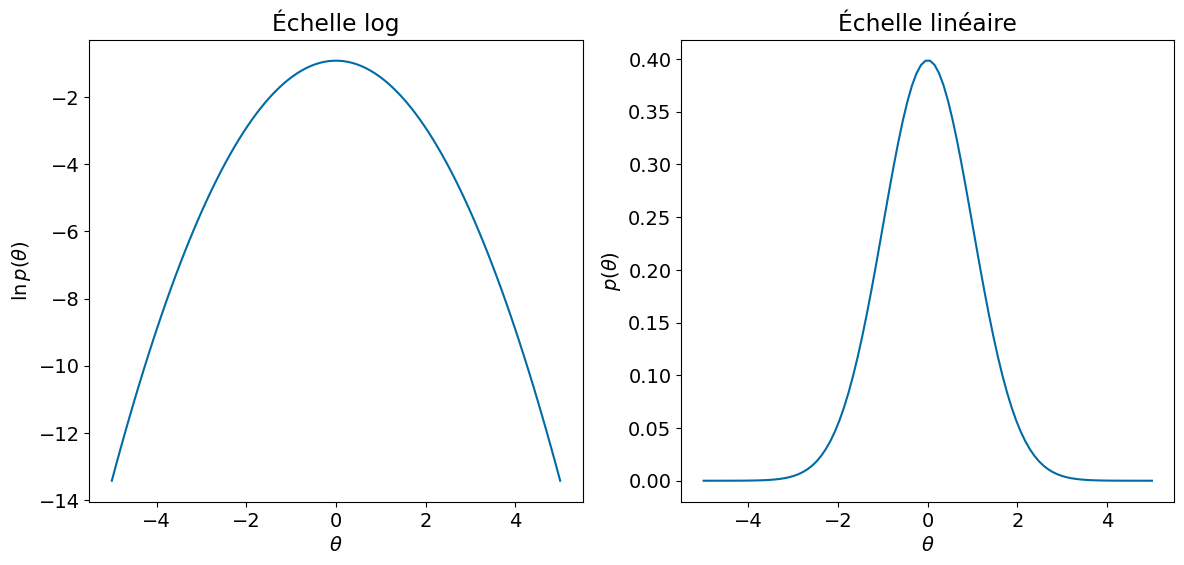

In [5]:
def log_likelihood(p: NDArray, mu: float = 0.0, sigma: float = 1.0) -> float:
    theta = p[0]  # On extrait le paramètre du tableau (pour faciliter la généralisation à plusieurs paramètres)
    return - 0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * (theta - mu)**2 / sigma**2

theta_vals = np.linspace(-5, 5, num=100)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
ll_vals = log_likelihood([theta_vals])
axs[0].plot(theta_vals, ll_vals)
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\ln p(\theta)$")
axs[0].set_title(r"Échelle log")
axs[1].plot(theta_vals, np.exp(ll_vals))
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$p(\theta)$")
axs[1].set_title(r"Échelle linéaire")
plt.show()

## Algorithme Nested Sampling

On peut maintenant implémenter le nested sampling.
Voici quelques suggestions ci-dessous.

- Pour commencer, utilisez un nombre fixe d'itérations (`nsteps`) au lieu d'un critère de convergence.
- Définissez une fonction `nested_sampling()` avec la signature suggérée ci-dessous. Les arguments sont:
  - `loglike_fn`: fonction log-vraisemblance, qui prend un argument `p` (vecteur du paramètre theta avec un seul élément).
  - `pt_fn`: fonction de _prior transform_
  - `ndim`: nombre de dimension du vecteur de paramètre (1, dans ce premier exemple)
  - `nlive`: nombre de live points. Commencez par quelques centaines. 500 fonctionne bien.
  - `nsteps`: nombre d'itérations maximum.
  - N'hésitez pas à coder une première version de votre algorithme hors de la fonction, pour avoir accès facilement aux variable et "débugger".
- Pour la génération de nouveaux "live points", vous pouvez utiliser le _rejection sampling_: générer des points sur tout le prior et accepter le premier point qui satisfait $L(\theta)>L_{\text{min}}$.
  - Ce n'est pas une manière efficace de générer des points. Je vous invite à tester des alternatives (e.g. MCMC à partir d'un _live point_ tiré au hasard, échantillonnage uniforme dans un ellipsoide) si le temps vous le permet.

In [7]:
def draw_new(loglike_fn: Callable, pt_fn: Callable, ll_min: float, ndim: int) -> tuple[NDArray, NDArray, float]:
    """Fonction pour échantillonner le likelihood au dessus d'un seuil minimum.

    :param loglike_fn: Fonction log-likelihood
    :param pt_fn: Prio transform
    :param ll_min: Valeur
    :param ndim: Nombre de dimensions
    :return: Paramètre et valeur de la log-vraisemblance
    """
    ll_new = -np.inf
    while ll_new <= ll_min:
        u = rng.uniform(size=ndim)
        p = pt_fn(u)
        ll_new = loglike_fn(p)
    return u, p, ll_new

def nested_sampling(loglike_fn: Callable, pt_fn: Callable, ndim: int, nlive: int, nstep: int, proposal_method: str = "rejection") -> dict:
    """Nested sampling

    :param loglike_fn: Fonction log-vraisemblance prenant un argument p de longueur 1
    :param pt_fn: Prior transform
    :param ndim: Nombre de dimension (1 dans cet exemple)
    :param nlive: Nombre de live points
    :param nstep: Nombre de pas (on utilise un nombre fixe dans cet exemple. En pratique on utiliserait un critère de convergence)
    :param proposal_method: Nom de la méthode de proposition à utiliser
    :return: Résultats dans un dictionnaire (X, Z, w, ll, samples)
    """
    # On génère d'abord les live points sur un "cube" uniforme
    u = rng.uniform(size=(ndim, nlive))
    p = pt_fn(u)  # On transforme vers l'espace du prior

    # On initialise le volume X et l'évidence Z
    Xprev = 1.0
    Zprev = 0.0

    # On aura besoin d'emmagasiner les "dead points" explorés au fil du temps
    dead_pts = np.empty((nstep, ndim))
    X = np.empty(nstep)
    Z = np.empty(nstep)
    w = np.empty(nstep)
    ll = np.empty(nstep)
    ll_live = np.array([loglike_fn(pi) for pi in p.T])

    for i in tqdm.tqdm(range(nstep)):
        # On trouve le point à ajouter aux "dead points"
        ind_min = np.argmin(ll_live)
        ll_min = ll_live[ind_min].copy()
        pmin = p[:, ind_min].copy()

        # Calcul du volume moyen pour chaque pas
        X[i] = np.exp(-i / nlive)

        # On emmagasine les infos du dead point et on passe à la prochaine itération
        dead_pts[i] = pmin
        ll[i] = ll_min
        w[i] = np.exp(ll_min) * (Xprev - X[i])
        Z[i] = Zprev + w[i]
        Zprev = Z[i]
        Xprev = X[i]
        # On tire un nouveau point et on remplace le dead point
        if proposal_method == "rejection":
            unew, pnew, ll_new = draw_new(loglike_fn, pt_fn, ll_min, ndim)
        elif proposal_method == "rwalk":
            try:
                unew, pnew, ll_new = draw_rwalk(loglike_fn, pt_fn, ll_min, u, 1000, log_prior)
            except Exception:
                raise RuntimeError("rwalk pas encore définie")
        else:
            raise ValueError(f"Proposal method {proposal_method} is unknown")
        u[:, ind_min] = unew
        p[:, ind_min] = pnew
        ll_live[ind_min] = ll_new

    results = {"X": X, "Z": Z, "w": w, "ll": ll, "samples": dead_pts}

    return results

results = nested_sampling(log_likelihood, prior_transform, 1, 500, 3000, proposal_method="rejection")
X, Z, w, ll, dead_pts = results["X"], results["Z"], results["w"], results["ll"], results["samples"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2309.13it/s]


Vous pouvez maintenant afficher différentes quantités en fonction du volume du prior (ou de son logarithme):

- L'évidence
- La (log-)vraisemblance
- Le poid des échantillons
- Un histogramme pondéré de la distribution à posteriori

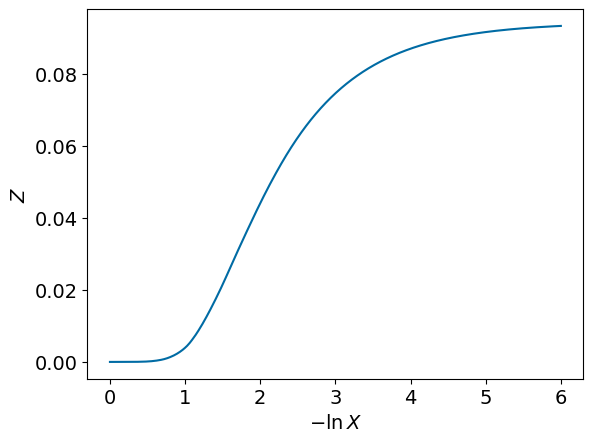

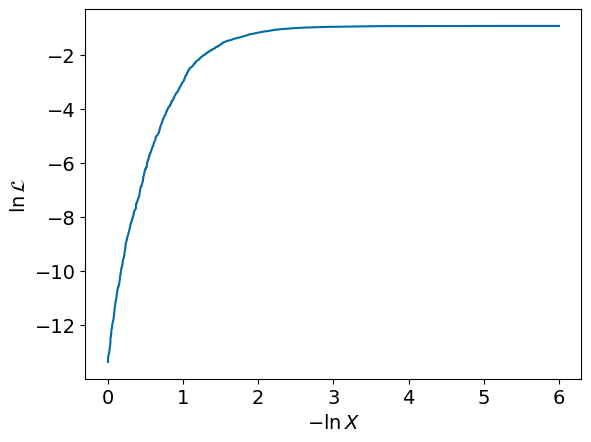

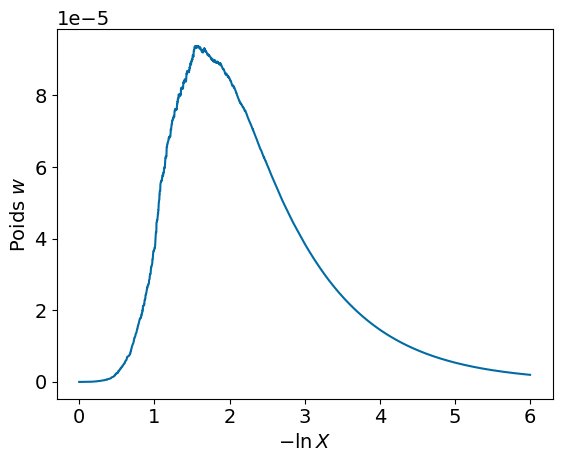

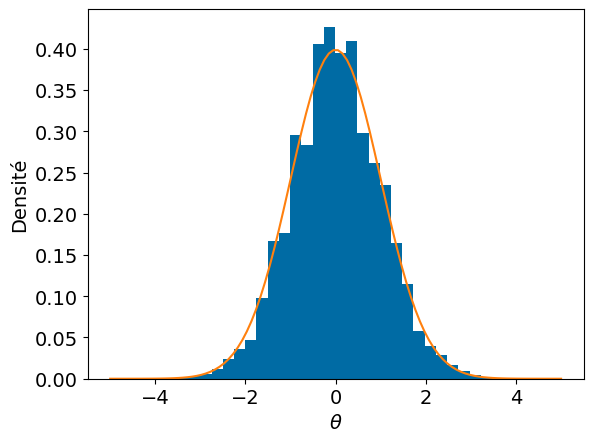

In [8]:
plt.plot(-np.log(X), Z)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"$Z$")
plt.show()

plt.plot(-np.log(X), ll)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"$\ln \mathcal{L}$")
plt.show()

plt.plot(-np.log(X), w)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"Poids $w$")
plt.show()

plt.hist(dead_pts, density=True, weights=w, bins=40)
plt.plot(theta_vals, np.exp([log_likelihood([t]) for t in theta_vals]))
plt.xlabel(r"$\theta$")
plt.ylabel("Densité")
plt.show()

## Exercices bonus
Si vous voulez explorer ce code un peu plus, voici quelques options. Elles ne seront pas évaluées, ni utilisées dans les devoir, mais elles sont intéressantes pour approfondir votre compréhension:

- Implémentez un échantillonnage par marche aléatoire
- Testez un modèle à deux paramètre (régression linéaire) avec ce code, comparez avec dynesty.

### MCMC

Dans ce cas-ci, notre MCMC sert à explorer la distribution a priori, et non la distribution a posteriori.

- Il faut donc utiliser une fonction `log_prior` pour explorer l'espace-paramètre. Définissez d'abord cette fonction.
- Il faut aussi rejeter les échantillons avec L < Lmin, en plus de l'acceptance MCMC habituelle.
- Pour l'échelle du MCMC, vous pouvez utiliser une distribution de proposition avec la taille du MCMC.
- Itérez un certain nombre d'itération (ex.: 1000) avant de prposer de nouveaux échantillons.

In [10]:
def log_prior(p: NDArray) -> float:
    p = p[0]
    if -5 <= p < 5:
        return - np.log(10)
    return - np.inf

def draw_rwalk(loglike_fn, pt_fn, ll_min, u, nsteps, log_prior):
    # Pick random live points from u
    u0 = rng.choice(u, axis=1)
    scale = np.std(u, axis=1)
    ndim = len(u0)

    ucur = u0
    u_arr = np.empty((nsteps, ndim))
    for i in range(nsteps):
        up = rng.normal(loc=ucur, scale=scale, size=ndim)
        xcur = pt_fn(ucur)
        xp = pt_fn(up)
        lp = loglike_fn(xp)
        r = rng.uniform(low=0.0, high=1.0)
        if (log_prior(xp) - log_prior(xcur)) > np.log(r) and lp > ll_min:
            ucur = up
        u_arr[i] = ucur

    xcur = pt_fn(ucur)
    ll_cur = loglike_fn(xcur)
    return ucur, xcur, ll_cur

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:26<00:00, 57.79it/s]


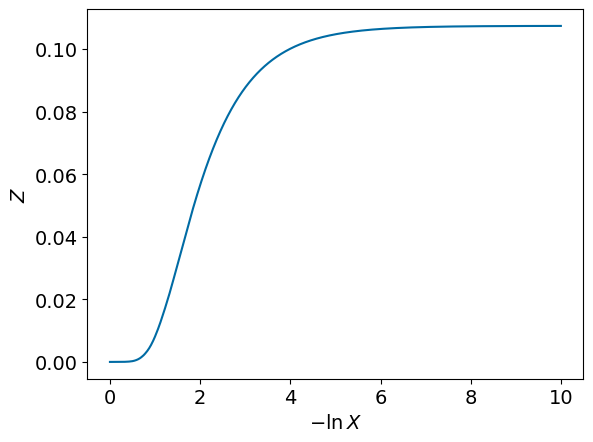

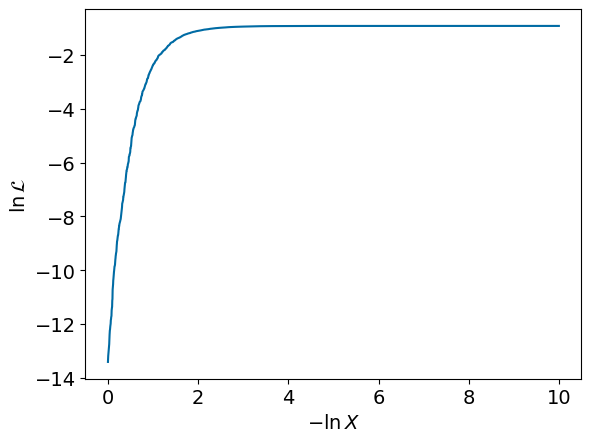

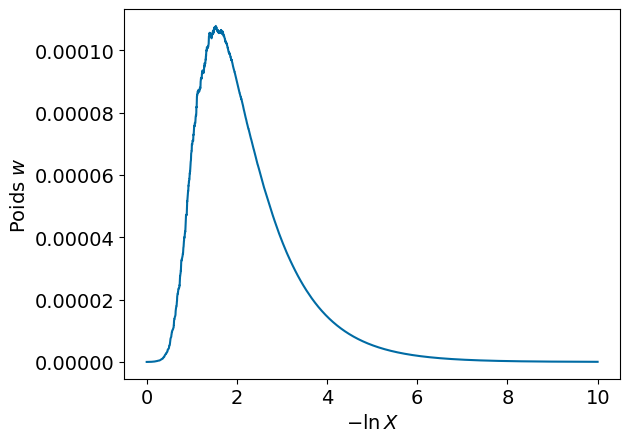

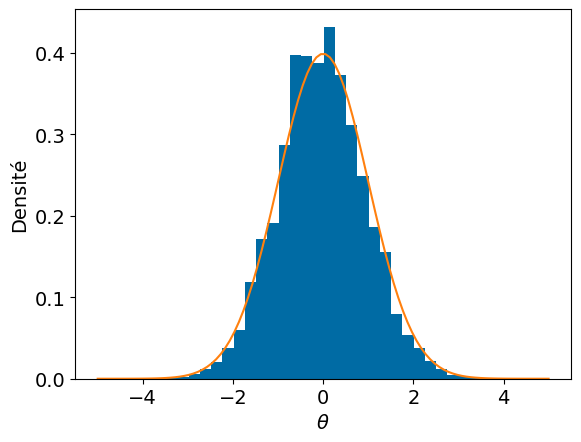

In [11]:
results = nested_sampling(log_likelihood, prior_transform, 1, 500, 5000, proposal_method="rejection")
X, Z, w, ll, dead_pts = results["X"], results["Z"], results["w"], results["ll"], results["samples"]

plt.plot(-np.log(X), Z)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"$Z$")
plt.show()

plt.plot(-np.log(X), ll)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"$\ln \mathcal{L}$")
plt.show()

plt.plot(-np.log(X), w)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"Poids $w$")
plt.show()

plt.hist(dead_pts, density=True, weights=w, bins=40)
plt.plot(theta_vals, np.exp([log_likelihood([t]) for t in theta_vals]))
plt.xlabel(r"$\theta$")
plt.ylabel("Densité")
plt.show()

### Régression linéaire

On simule d'abord les données, on définit notre modèle probabiliste, et on lance ensuite le nested sampling.



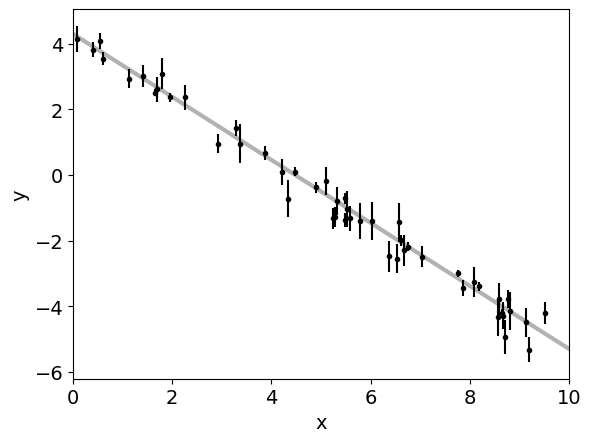

In [12]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534

N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

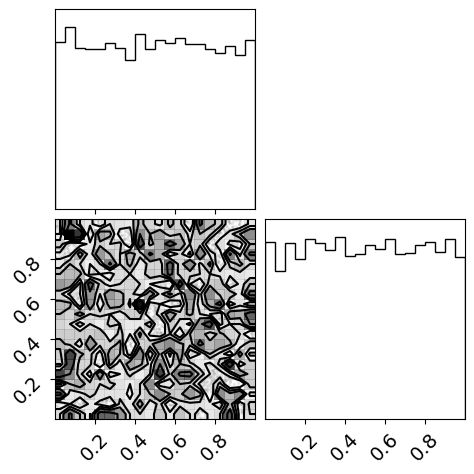

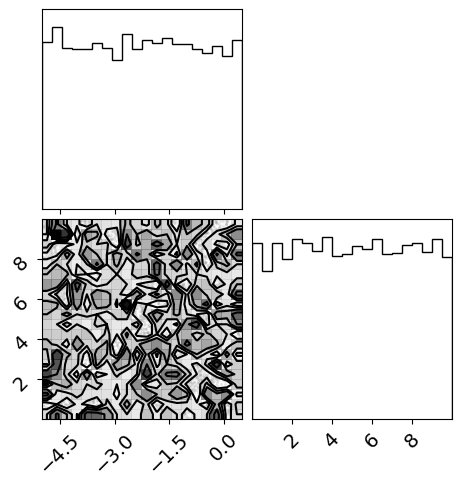

In [13]:
def log_likelihood(theta):
    m, b = theta
    model = m * x + b
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

def prior_transform(u: NDArray) -> NDArray:

    x = u.copy()
    x[0] = u[0] * 5.5 - 5
    x[1] = u[1] * 10
    return x

u_test = rng.uniform(size=(2, 10000))
p_test = prior_transform(u_test)

import corner

corner.corner(u_test.T)
plt.show()

corner.corner(p_test.T)
plt.show()

In [14]:
results = nested_sampling(log_likelihood, prior_transform, 2, 500, 10000, proposal_method="rwalk")
X, Z, w, ll, dead_pts = results["X"], results["Z"], results["w"], results["ll"], results["samples"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:35<00:00, 36.27it/s]


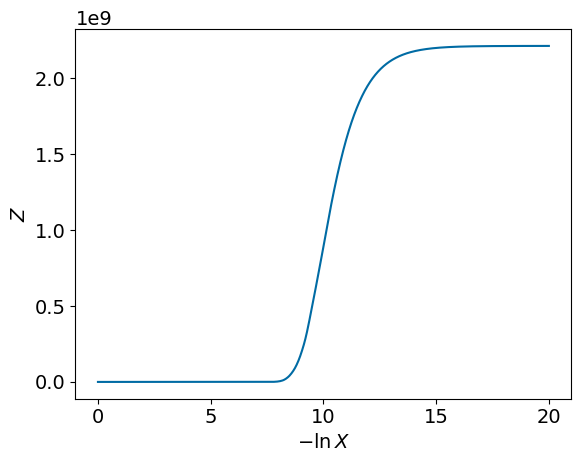

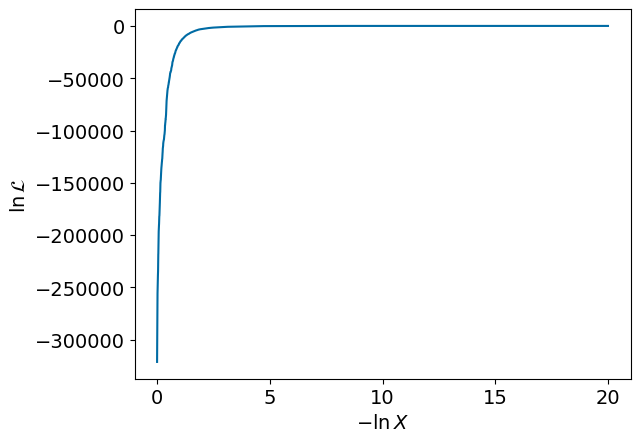

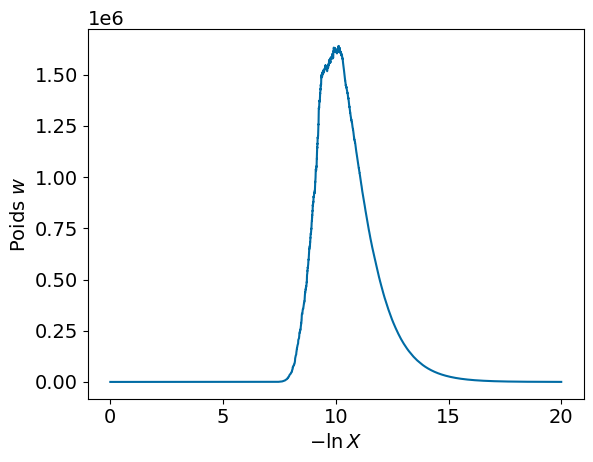

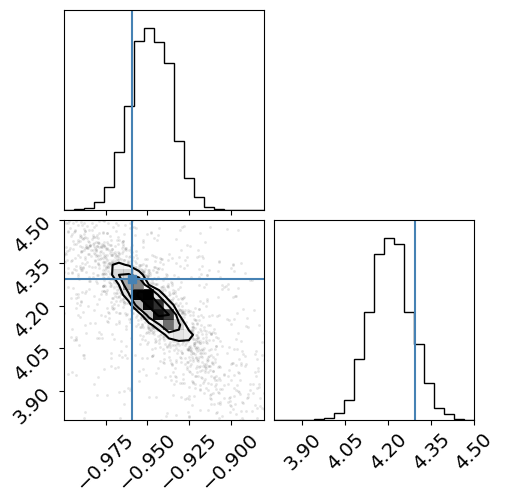

In [15]:
plt.plot(-np.log(X), Z)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"$Z$")
plt.show()

plt.plot(-np.log(X), ll)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"$\ln \mathcal{L}$")
plt.show()

plt.plot(-np.log(X), w)
plt.xlabel(r"$-\ln X$")
plt.ylabel(r"Poids $w$")
plt.show()

# Il faut ajuster le corner plot pour le recardrer autour des échantillons avec un poid significatif.
corner.corner(dead_pts, weights=w, range=[(-1.0, -0.88), (3.8, 4.5) ], plot_datapoints=True, truths=[m_true, b_true])
plt.show()